# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import yfinance as yf
import arch
import riskfolio as rp

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
tic=pd.read_excel('TIC.xlsx')

In [3]:
tic

,Nomi,Pesi,Ticker
0,S&P 500,0.21,^GSPC
1,CONV BOND,0.07,GCVB.L
2,EUR SHORT BOND,0.15,ERNE.L
3,INFL LINKED,0.05,EMI.MI
4,GOLD,0.16,GLD
5,MSCI WORLD,0.20,MWL=F
6,US TREASURY,0.06,SHV
7,COMMODITIES,0.06,DBC
8,EUR LONG BOND,0.04,BLV


In [4]:
tickers=list(tic['Ticker'])
tickers.sort()

In [5]:
tickers

['BLV', 'DBC', 'EMI.MI', 'ERNE.L', 'GCVB.L', 'GLD', 'MWL=F', 'SHV', '^GSPC']

In [6]:
data=yf.download(tickers,interval='1d')[['Adj Close']]

[*********************100%***********************]  9 of 9 completed


In [7]:
data.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

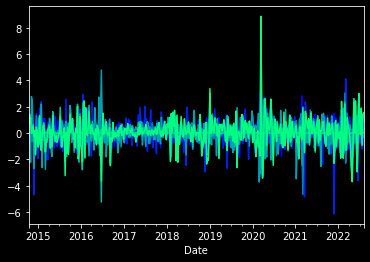

In [8]:
plt.style.use('dark_background')

rets=((np.log(data) - np.log(data.shift(1))).dropna()*100).resample('W').ffill()

rets.plot(legend=False,cmap='winter')

<AxesSubplot:xlabel='Date'>

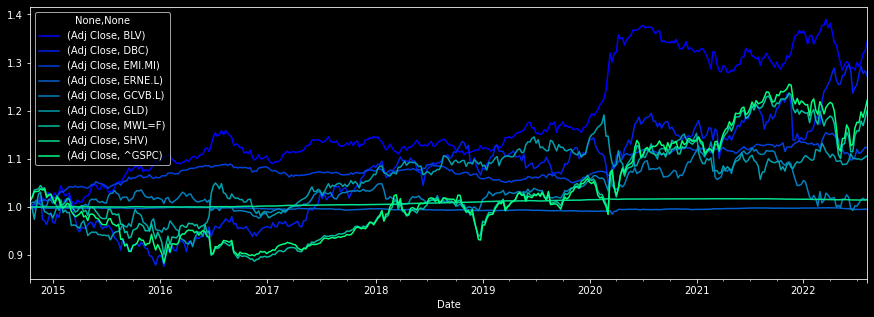

In [9]:
(rets/100+1).cumprod().plot(figsize=(15,5),cmap='winter')

# Sample mean

Assumiamo che la sample mean sia informativa

In [10]:
rets.columns=tickers
model={}
result={}
for i in tickers:
    model[i]=arch.univariate.ConstantMean(rets.loc[:,i])
    result[i]=model[i].fit(disp="off")

# Monte Carlo

Assumiamo che i rendimenti seguano una distribuzione multivariata con t di student (con 8 gradi di libertà)

i.e. $R_t \sim MVT(\mu, \Sigma)$

Usiamo la fattorizzazione di Cholesky per trovare la matrice triangolare inferiore $L$ tale che $LL'=\Sigma$

Quindi i rendimenti degli asset possono essere descritti come:

$R_T=\mu + L Z_t$

Dove $Z_t\sim  student \ t_{n=8}$

In [11]:
n_t=52
n_mc=5000

In [12]:
weights=np.array(tic.iloc[:,1])

## Sample mean

In [13]:
mu={}
for i in tickers:
    mu[i]=result[i].params['mu']/100
mu_df=pd.DataFrame.from_dict(mu,orient='index')

## Var/Cov Matrix con denoising and detoning

In [14]:
cov=rp.ParamsEstimation.covar_matrix(rets/100,method='fixed')

In [15]:
from datetime import datetime, timedelta


## Loop

In [16]:
portf_returns = np.full((n_t,n_mc),0.)

for i in range(0,n_mc):
    Z = np.random.standard_t(12,size=len(tickers)*n_t)
    Z = Z.reshape((len(tickers),n_t))
    L = np.linalg.cholesky(cov)
    wkrets=np.inner(L,np.transpose(Z))+np.array(mu_df)
    portf_r = np.cumprod(np.inner(weights,np.transpose(wkrets)) + 1)
    future_dates = [rets.index[-1] + timedelta(weeks=x) for x in range(0,n_t+1)]
    portf_returns[:,i] = portf_r

## Funzioni

In [17]:
def band(r,n_t=n_t):
    y2=r
    y1=1
    lt2=np.log(n_t)
    b=(y2-y1)/lt2
    a=y1

    U= np.zeros([n_t + 1, 1])
    for t in range(0, int(n_t)+1):
      U[t] = a+b*np.log(t+1)
    U_df=pd.DataFrame(U,index=future_dates)
    return U_df

In [18]:
def trend(r,n_t=n_t):
    L= np.zeros([n_t + 1, 1])
    L[0]=1
    for t in range(1, int(n_t)+1):
      L[t] = L[t-1]*(r**(1/n_t))
    L_df=pd.DataFrame(L,index=future_dates)
    return L_df

## Grafico

In [19]:
ptf_returns=np.insert(portf_returns, 0, 1, axis=0)

In [20]:
hist=((rets@weights)/100+1).cumprod()

[]

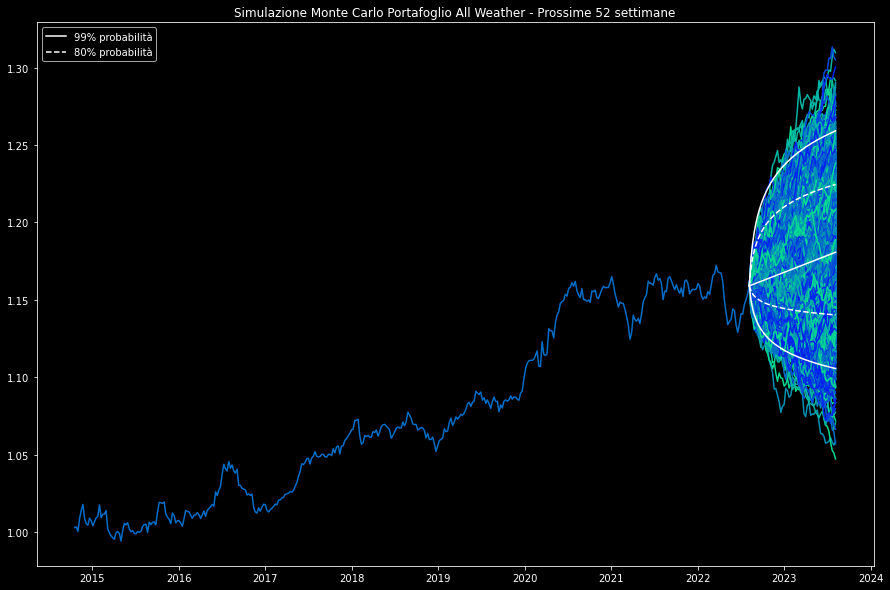

In [21]:

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

with sns.color_palette("winter"):
    plt.plot(hist[-1]*pd.DataFrame(ptf_returns,index=future_dates))

    
plt.plot(hist)
    
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.99)),color='white', label='99% probabilità')
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.01)),color='white',)
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.9)),color='white', label='80% probabilità',linestyle='dashed')
plt.plot(hist[-1]*band(np.quantile(portf_returns[-1],q=0.1)),color='white', linestyle='dashed')



plt.plot(hist[-1]*trend(np.quantile(portf_returns[-1],q=0.5)),color='white')
plt.title('Simulazione Monte Carlo Portafoglio All Weather - Prossime 52 settimane')
plt.legend()
plt.plot()

In [22]:
print('Nel 99% dei casi non dovresti perdere più del: ' +str((np.quantile(portf_returns[-1],q=0.01)-1)*100))
print('Nel 99% dei casi non dovresti guadagnare più del: ' +str((np.quantile(portf_returns[-1],q=0.99)-1)*100))

Nel 99% dei casi non dovresti perdere più del: -4.5840154080329825
Nel 99% dei casi non dovresti guadagnare più del: 8.5925273568213


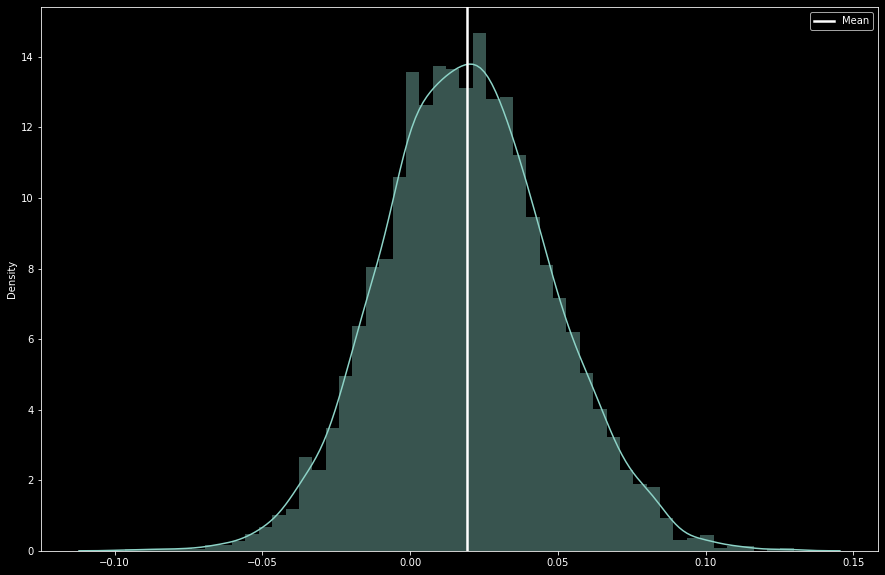

In [23]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)


sns.distplot(portf_returns[-1]-1)

plt.axvline((portf_returns[-1]-1).mean(), c='white', ls='-', lw=2.5, label='Mean')
plt.legend()

# Analisi storica All Weather

In [24]:
import pyfolio

Start date,2014-10-26
End date,2022-08-07
Total months,19
,Backtest
Annual return,9.4%
Cumulative returns,15.6%
Annual volatility,5.7%
Sharpe ratio,1.60
Calmar ratio,2.54
Stability,0.93
Max drawdown,-3.7%


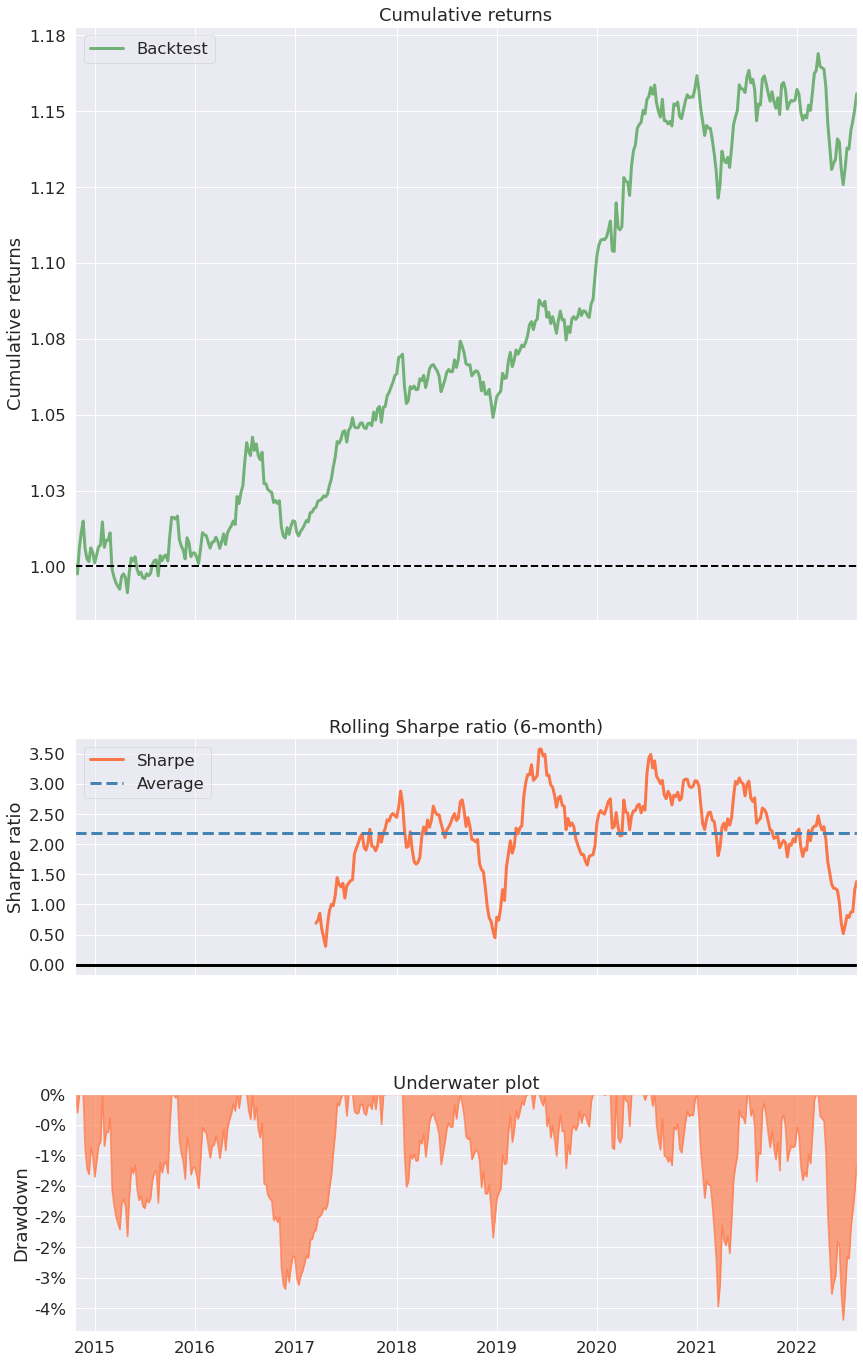

In [25]:
pyfolio.create_simple_tear_sheet(hist.pct_change().dropna())

